In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic-passenger-data/README.md
/kaggle/input/spaceship-titanic-passenger-data/data/sample_submission.csv
/kaggle/input/spaceship-titanic-passenger-data/data/train.csv
/kaggle/input/spaceship-titanic-passenger-data/data/test.csv


<h3>Import Libraries</h3>

In [2]:
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
import warnings

<h3>Feature Selection</h3>

In [3]:
train_data = pd.read_csv("/kaggle/input/spaceship-titanic-passenger-data/data/train.csv")

In [4]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


<h5>We can see that for some of the features, there are values that are missing (null values). Therefore, we must take action. Since, at most, there are about 2.3% of the 8693 entries that are missing for one feature, it would be better to impute (or fill out) those missing values.</h5>

<h3>Deleting Non-Important Columns</h3>

<h5>Since the features "Name" and "PassengerId" are unique identifiers, they may not affect the results as much as the other features. For this reason, we wil remove these two columns from the data.</h5>

In [6]:
train_data.drop(['PassengerId', 'Name'], axis=1, inplace=True)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(5)
memory usage: 755.7+ KB


<h3>Missing Value Handling</h3>

In [8]:
# print out the unique values for each feature that contains at least
# one null value
for column in train_data.columns:
    if train_data[column].isnull().any():
        unique_vals = train_data[column].unique()
        print(f"{column}: {unique_vals}")
        print(f"Length of Unique Values: {len(unique_vals)}")
        print()

HomePlanet: ['Europa' 'Earth' 'Mars' nan]
Length of Unique Values: 4

CryoSleep: [False True nan]
Length of Unique Values: 3

Cabin: ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
Length of Unique Values: 6561

Destination: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
Length of Unique Values: 4

Age: [39. 24. 58. 33. 16. 44. 26. 28. 35. 14. 34. 45. 32. 48. 31. 27.  0.  1.
 49. 29. 10.  7. 21. 62. 15. 43. 47.  2. 20. 23. 30. 17. 55.  4. 19. 56.
 nan 25. 38. 36. 22. 18. 42. 37. 13.  8. 40.  3. 54.  9.  6. 64. 67. 61.
 50. 41. 57. 11. 52. 51. 46. 60. 63. 59.  5. 79. 68. 74. 12. 53. 65. 71.
 75. 70. 76. 78. 73. 66. 69. 72. 77.]
Length of Unique Values: 81

VIP: [False True nan]
Length of Unique Values: 3

RoomService: [   0.  109.   43. ... 1569. 8586.  745.]
Length of Unique Values: 1274

FoodCourt: [   0.    9. 3576. ... 3208. 6819. 4688.]
Length of Unique Values: 1508

ShoppingMall: [   0.   25.  371. ... 1085.  510. 1872.]
Length of Unique Values: 1116

Spa: [   0. 

<h5>First, I want to split the 'Cabin' column into three separate columns to split the deck, num, and side into their own columns to better process the data. </h5>

In [9]:
deck_col = []
num_col = []
side_col = []

# go through the Cabin column to separate the details of the passenger's 
# location into three (deck, num, side) so that they can be in their 
# own column. 
for val in train_data['Cabin']:
    # Check if the value is a missing value
    if pd.notna(val):
        # split the string
        deck, num, side = val.split('/')
        
        deck_col.append(deck)
        num_col.append(int(num))
        side_col.append(side)
    else:
        # Add the "Unknown" string to the columns to represent a missing
        # value
        deck_col.append('Unknown')
        num_col.append('Unknown')
        side_col.append('Unknown')
        
train_data_new = train_data.drop('Cabin', axis=1)
train_data_new['Deck'] = deck_col
train_data_new['Num'] = num_col
train_data_new['Num'] = pd.to_numeric(train_data_new['Num'], errors='coerce')
train_data_new['Side'] = side_col

In [10]:
train_data_new.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0.0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0.0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0.0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0.0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1.0,S


In [11]:
train_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   bool   
 11  Deck          8693 non-null   object 
 12  Num           8494 non-null   float64
 13  Side          8693 non-null   object 
dtypes: bool(1), float64(7), object(6)
memory usage: 891.5+ KB


<h5>For string objects, we will just replace the null values with the string 'Unknown'. For the age, VRDeck, Spa, ShoppingMall, FoodCourt, RoomService feature, we will replace the null values with the median age.</h5>

In [12]:
# go through each column with nulls in it and replace them with the appropriate value
for column in train_data_new.columns:
    if train_data_new[column].isnull().any():
        if train_data_new[column].dtype == 'object':
            train_data_new[column] = train_data_new[column].fillna('Unknown')          
        elif train_data_new[column].dtype == 'float64':
            median = train_data_new[column].median()
            train_data_new[column] = train_data_new[column].fillna(median)

In [13]:
train_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   object 
 2   Destination   8693 non-null   object 
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   object 
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Transported   8693 non-null   bool   
 11  Deck          8693 non-null   object 
 12  Num           8693 non-null   float64
 13  Side          8693 non-null   object 
dtypes: bool(1), float64(7), object(6)
memory usage: 891.5+ KB


<h3>Numerical Values Analysis</h3>

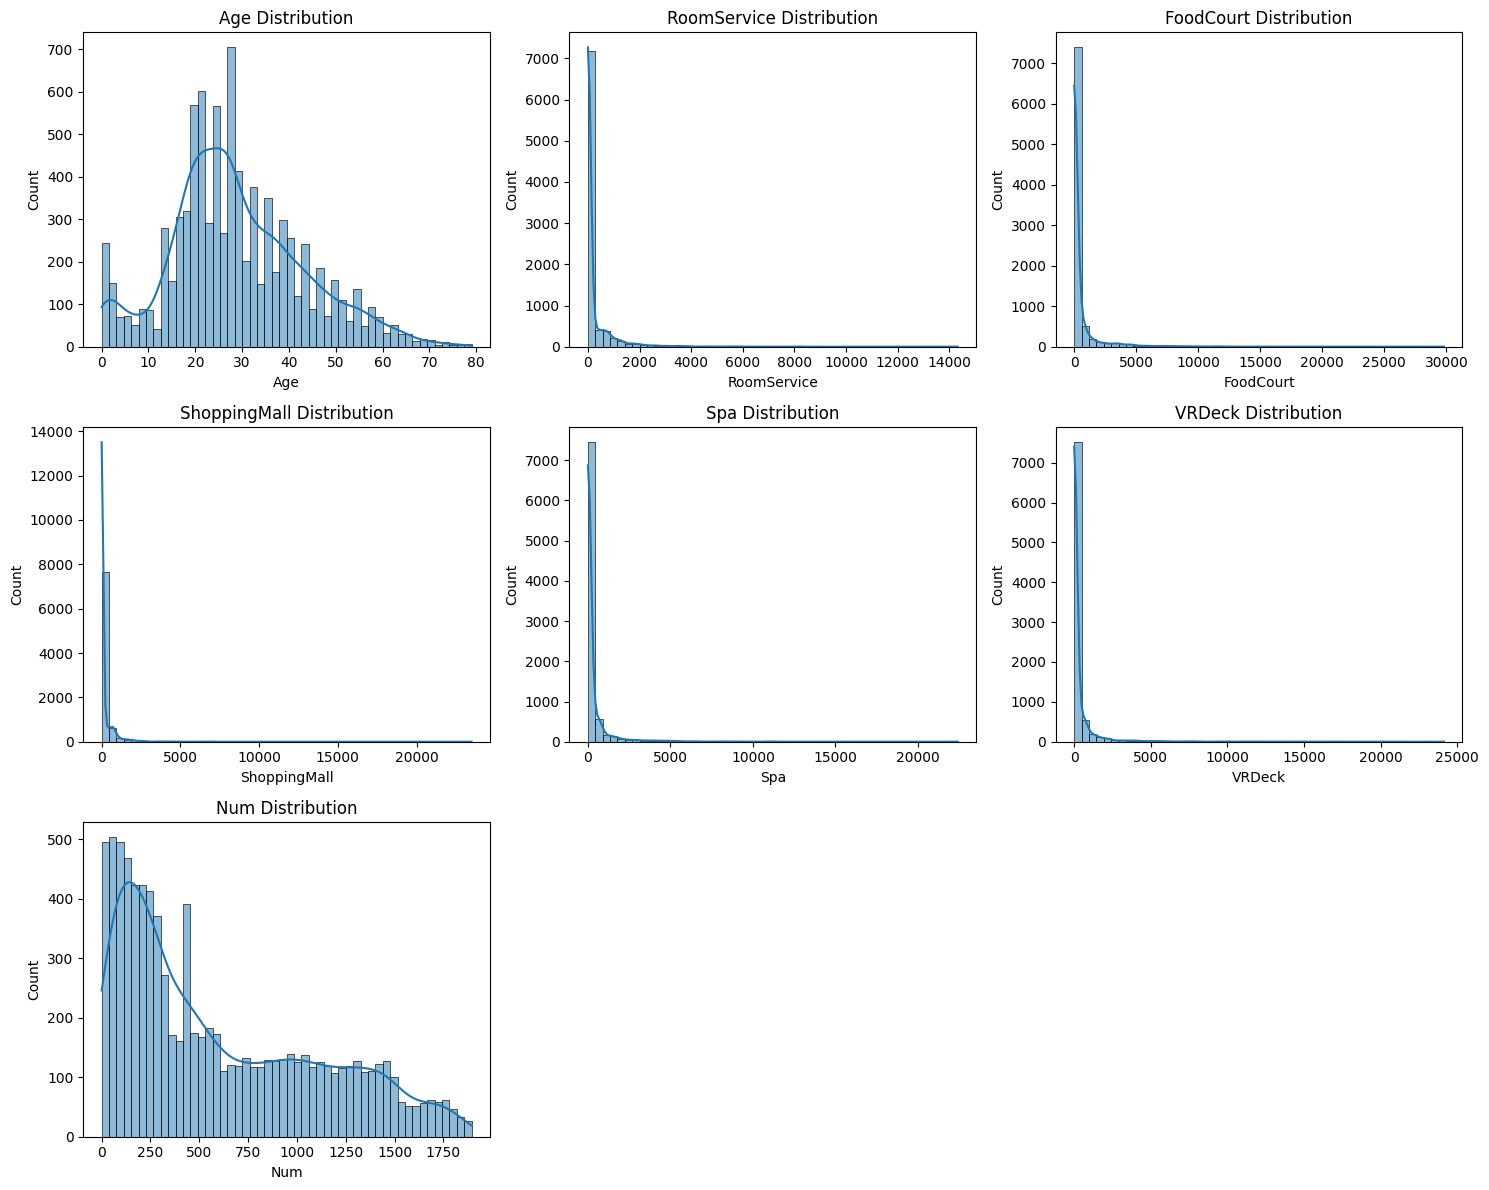

In [14]:
# Select numerical columns
num_cols = train_data_new.select_dtypes(include='number').columns

# Set up the grid
n_cols = 3
n_rows = -(-len(num_cols) // n_cols)  # Ceiling division
plt.figure(figsize=(5 * n_cols, 4 * n_rows))

# Plot each histogram
for i, col in enumerate(num_cols, 1):
    warnings.filterwarnings("ignore")
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(train_data_new[col], kde=True, bins=50)
    plt.title(f'{col} Distribution')

plt.tight_layout()
plt.show()

<h5>You can see that the distribution for the "Age" feature is close to being normally distributed, while the distribution of the "Num" feature is skewed to the right (positively skewed). The rest of the features are greatly right skewed.</h5>

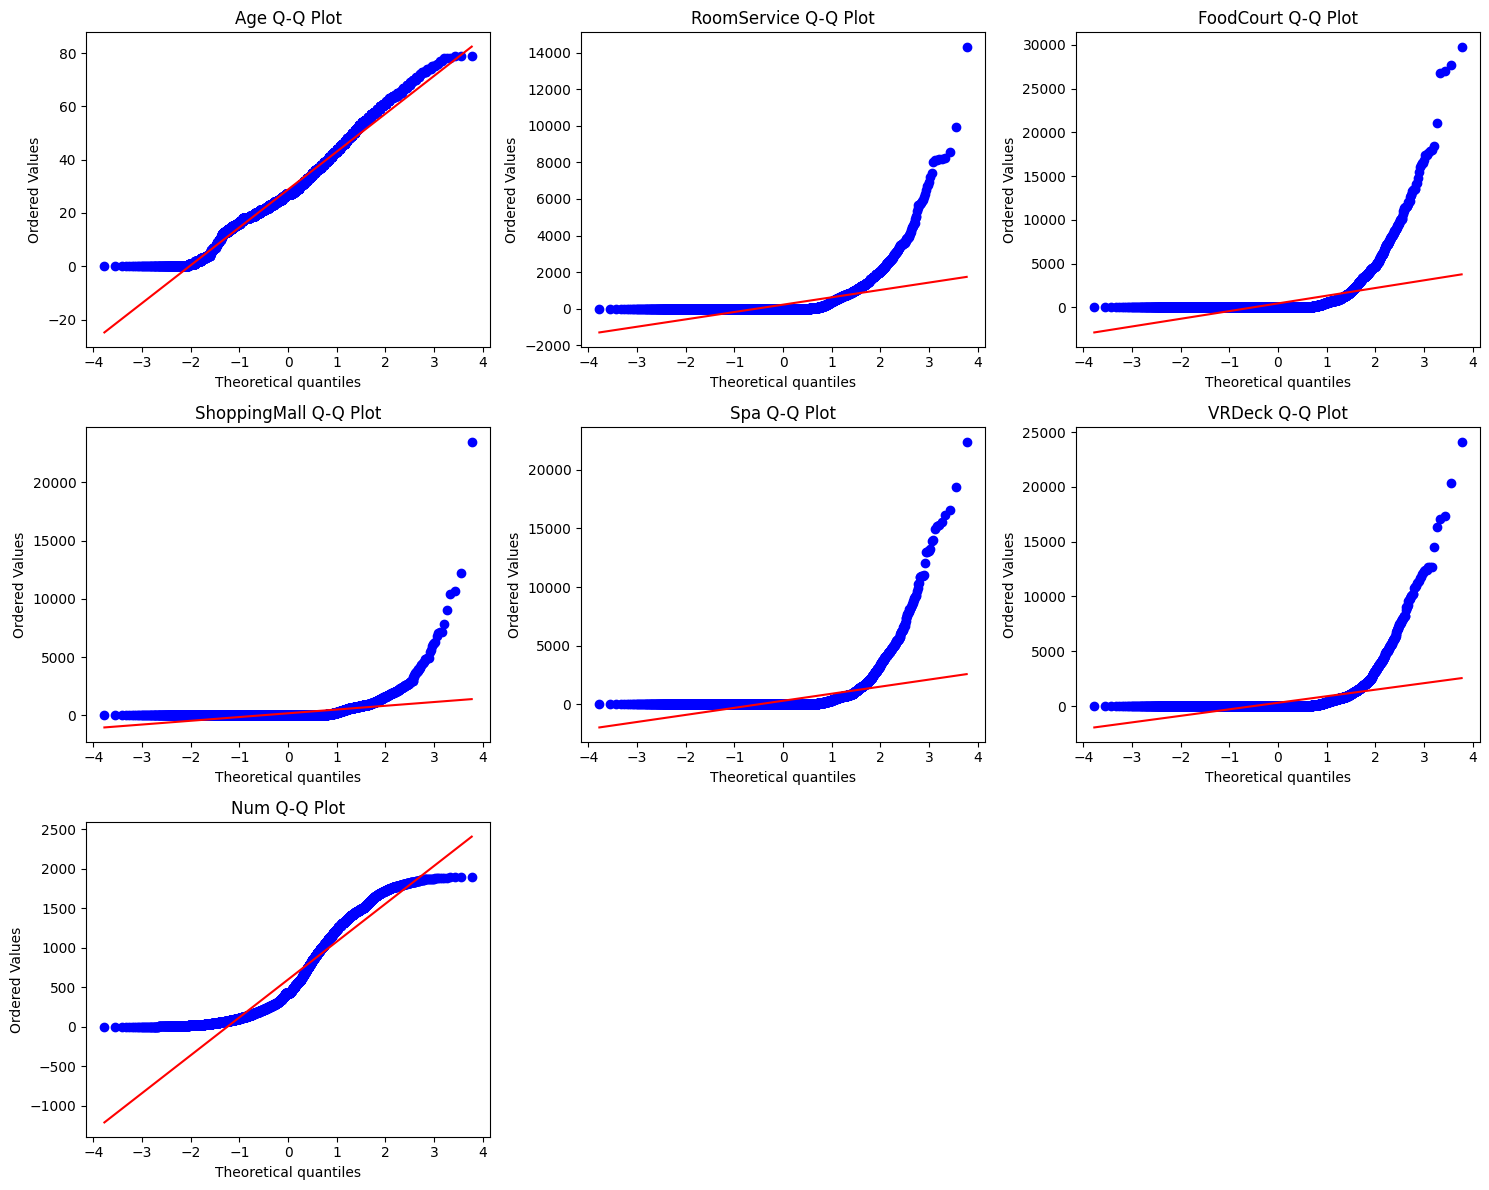

In [15]:
# Set up the grid
plt.figure(figsize=(5 * n_cols, 4 * n_rows))

# Plot each Q-Q plot
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    stats.probplot(train_data_new[col].dropna(), dist="norm", plot=plt)
    plt.title(f'{col} Q-Q Plot')

plt.tight_layout()
plt.show()

<h5>The Q-Q plots confirm the results from the histograms by showing that the "Age" feature is mostly normally distributed and the 'num' feature is rightly skewed. The other features seem to also be right-skewed, as shown by the blue line switching between first above the red line and then below the red line and so on. Let's finally confirm this by analyzing them numerically rather than visually.</h5>

In [16]:
# go through each column with numerical values and find its skew value
for col in train_data_new.columns:
    if train_data_new[col].dtype == 'float64':
        skew_value = train_data_new[col].skew()
        print(f"{col} Skew Value: {skew_value}")

Age Skew Value: 0.43110235678108527
RoomService Skew Value: 6.397765852484436
FoodCourt Skew Value: 7.177515190964732
ShoppingMall Skew Value: 12.763842149564473
Spa Skew Value: 7.716449618352362
VRDeck Skew Value: 7.9045544151027824
Num Skew Value: 0.7464580436841154


<h5>Values between -0.5 and 0.5 are normally distributed, and anything >0.5 is right skewed. You can see that the values match the observations made with the Q-Q plots. Now, let's see how many outliers each numerical feature has.</h5>

<h3>Outlier and Noise Handling</h3>

<h5>We will use the interquartile range to determine the outlier count.</h5>

In [17]:
def detect_outliers_iqr(df):
    outlier_flags = {}
    for col in df.select_dtypes(include='number').columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        outlier_flags[col] = len(outliers)
    return pd.Series(outlier_flags).sort_values(ascending=False)

In [18]:
outliers = detect_outliers_iqr(train_data_new)
outliers

FoodCourt       1916
RoomService     1906
ShoppingMall    1879
VRDeck          1849
Spa             1833
Age              162
Num                0
dtype: int64

<h5>We can see that for the features "Age" and "Num", the outliers wouldn't affect the model that will be used later for classification as much as the other 5 features (which have >20% of their values being outliers). So, we need to focus on those features and figure out what to do with them.</h5>

<h5>As you can see, the features that have a lot of outliers are the ones representing the money spent on amenities. These could be realistic since the passenger may be a VIP passenger or just a wealthy one who has spent a lot on an amenity they enjoy. So, it may be better to keep those datapoints, but can instead transform those features so that the outliers won't affect the results later on, especially for models that are affected by outliers.</h5>

In [19]:
# go through the features with a lot of outliers and use the log function to transform
# the values to reduce the impact of the outliers.  
for col in train_data_new.select_dtypes(include='number').columns:
    if col != 'Age' and col != 'Num':
        train_data_new[f'{col}_log'] = np.log1p(train_data_new[col])

In [20]:
train_data_new.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,RoomService_log,FoodCourt_log,ShoppingMall_log,Spa_log,VRDeck_log
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0.0,P,0.000000,0.000000,0.000000,0.000000,0.000000
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0.0,S,4.700480,2.302585,3.258097,6.309918,3.806662
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0.0,S,3.784190,8.182280,0.000000,8.812248,3.912023
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0.0,S,0.000000,7.157735,5.918894,8.110728,5.267858
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1.0,S,5.717028,4.262680,5.023881,6.338594,1.098612


<h3>Turning Categorical Values into Numerical</h3>

<h5>Since ML models usually take in numerical data, we must turn the columns with string types into numerical values. One way to do this is through one-hot encoding. Pandas has a built-in method that can do one-hot encoding for the columns in a DataFrame, so we will use that.</h5>

In [21]:
col = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
train_data_encoded = pd.get_dummies(train_data_new, columns=col)

In [22]:
train_data_encoded.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Num,RoomService_log,FoodCourt_log,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown,Side_P,Side_S,Side_Unknown
0,39.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.000000,0.000000,...,False,False,False,False,False,False,False,True,False,False
1,24.0,109.0,9.0,25.0,549.0,44.0,True,0.0,4.700480,2.302585,...,False,False,False,True,False,False,False,False,True,False
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0.0,3.784190,8.182280,...,False,False,False,False,False,False,False,False,True,False
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,0.0,0.000000,7.157735,...,False,False,False,False,False,False,False,False,True,False
4,16.0,303.0,70.0,151.0,565.0,2.0,True,1.0,5.717028,4.262680,...,False,False,False,True,False,False,False,False,True,False


<h3>Feature Scaling</h3>

<h5>Now, to make sure all the numerical values are on the same scale(not including the one-hot encodings), we will scale them. Since there exist some outliers, standardization is a better option than normalization. Going to create two dataframes, one where the features with outliers were not transformed with the log function, and one where the features with outliers were transformed. This is because some of the models aren't affected by outliers, so I want to see which dataframe works better with those models.</h5>

In [23]:
scaler = StandardScaler()
train_data_scaled = train_data_encoded.copy(deep=True).drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], axis=1)
train_data_not_transformed = train_data_encoded.copy(deep=True).drop(['RoomService_log', 'FoodCourt_log', 'ShoppingMall_log', 'Spa_log', 'VRDeck_log'], axis=1)

# go through each column with numerical values (not including one-hot encodings)
# and standardize them
for col1, col2 in zip(train_data_scaled.select_dtypes(include='number').columns, train_data_not_transformed.select_dtypes(include='number').columns):
    train_data_scaled[col1] = scaler.fit_transform(train_data_scaled[[col1]])
    train_data_not_transformed[col2] = scaler.fit_transform(train_data_not_transformed[[col2]])

In [24]:
train_data_scaled.head()

,Age,Transported,Num,RoomService_log,FoodCourt_log,ShoppingMall_log,Spa_log,VRDeck_log,HomePlanet_Earth,HomePlanet_Europa,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown,Side_P,Side_S,Side_Unknown
0,0.711945,False,-1.177238,-0.638181,-0.650080,-0.622995,-0.664035,-0.640034,False,True,...,False,False,False,False,False,False,False,True,False,False
1,-0.334037,True,-1.177238,1.090491,0.135040,0.646081,1.614565,0.745894,True,False,...,False,False,False,True,False,False,False,False,True,False
2,2.036857,False,-1.177238,0.753511,2.139858,-0.622995,2.518191,0.784254,False,True,...,False,False,False,False,False,False,False,False,True,False
3,0.293552,False,-1.177238,-0.638181,1.790516,1.682500,2.264863,1.277886,False,True,...,False,False,False,False,False,False,False,False,True,False
4,-0.891895,True,-1.175264,1.464342,0.803380,1.333879,1.624920,-0.240051,True,False,...,False,False,False,True,False,False,False,False,True,False


In [25]:
train_data_not_transformed.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Num,HomePlanet_Earth,HomePlanet_Europa,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown,Side_P,Side_S,Side_Unknown
0,0.711945,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,False,-1.177238,False,True,...,False,False,False,False,False,False,False,True,False,False
1,-0.334037,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,True,-1.177238,True,False,...,False,False,False,True,False,False,False,False,True,False
2,2.036857,-0.268001,1.959998,-0.283579,5.695623,-0.219796,False,-1.177238,False,True,...,False,False,False,False,False,False,False,False,True,False
3,0.293552,-0.333105,0.523010,0.336851,2.687176,-0.092818,False,-1.177238,False,True,...,False,False,False,False,False,False,False,False,True,False
4,-0.891895,0.125652,-0.237159,-0.031059,0.231374,-0.261240,True,-1.175264,True,False,...,False,False,False,True,False,False,False,False,True,False


<h3>Feature Selection</h3>

<h5>Now, to have the optimal dataset to use for the ML models, we need to find out which features are important and which are not to further clean the dataset. We will use three methods to figure out the important features.</h5>

In [26]:
correlations = {}
p_scores = {}

for col in train_data_scaled.select_dtypes(include='number').columns:
    corr, p = pointbiserialr(train_data_scaled[col], train_data_scaled['Transported'])
    correlations[col] = corr
    p_scores[col] = p

# Sort and display
print(pd.Series(correlations).sort_values(ascending=False))
pd.Series(p_scores).sort_values(ascending=False)

Num                -0.044502
Age                -0.074233
FoodCourt_log      -0.135029
ShoppingMall_log   -0.178536
VRDeck_log         -0.338688
RoomService_log    -0.356220
Spa_log            -0.361903
dtype: float64


Num                  3.315266e-05
Age                  4.216286e-12
FoodCourt_log        1.181515e-36
ShoppingMall_log     3.500258e-63
VRDeck_log          2.908178e-232
RoomService_log     1.950700e-258
Spa_log             2.762929e-267
dtype: float64

<h5>We can see that "VRDeck_log", "RoomService_log", and "Spa_log" have strong negative correlations. "FoodCourt_log" and "ShoppingMall_log" have low to moderate negative correlations, so possibly they are not as important as those other features for determining if the passenger was transported or not. That could definitely be true for the "Num" and "Age" features that have almost no correlation to whether the passengers were transported or not. You can also see that most of them are statistically significant, especially the features with high correlation, so for sure those will be used in model training. The others, although weak in correlation, are still significant (not as high as the high correlated features though), so they will need further testing in model training and testing (by simply removing one by one). </h5>

In [27]:
correlations = {}
p_scores = {}

for col in train_data_not_transformed.select_dtypes(include='number').columns:
    corr, p = pointbiserialr(train_data_not_transformed[col], train_data_not_transformed['Transported'])
    correlations[col] = corr
    p_scores[col] = p

# Sort and display
print(pd.Series(correlations).sort_values(ascending=False))
pd.Series(p_scores).sort_values(ascending=False)

FoodCourt       0.045583
ShoppingMall    0.009391
Num            -0.044502
Age            -0.074233
VRDeck         -0.204874
Spa            -0.218545
RoomService    -0.241124
dtype: float64


ShoppingMall     3.813140e-01
Num              3.315266e-05
FoodCourt        2.122241e-05
Age              4.216286e-12
VRDeck           4.969701e-83
Spa              1.701990e-94
RoomService     3.205394e-115
dtype: float64

<h5>For the non-transformed data, we can see that "FoodCourt" and "ShoppingMall" features have almost no correlation with whether the passengers have been transported or not. The others have similar results, but the features that had a moderate negative correlation to the target column have weak correlations now. This could possibly be the fact that the outliers were kept, affecting correlation results. The statistical significance stayed about the same, so the same testing must be done for this dataset as well.</h5>

In [28]:
categorical_columns = [col for col in train_data_new.columns if train_data_new[col].dtype == 'object']
chi2_scores = {}
p_scores = {}

for col in categorical_columns:
    table = pd.crosstab(train_data_new[col], train_data_new['Transported'])
    chi2, p, _, _ = chi2_contingency(table)
    chi2_scores[col] = chi2
    p_scores[col] = p

# Sort and display
print(pd.Series(chi2_scores).sort_values(ascending=False))
pd.Series(p_scores).sort_values(ascending=False)

CryoSleep      1861.749116
Deck            392.288750
HomePlanet      324.967237
Destination     106.394882
Side             91.475193
VIP              12.097472
dtype: float64


VIP            2.360845e-03
Side           1.369034e-20
Destination    6.547434e-23
HomePlanet     3.921492e-70
Deck           8.352488e-80
CryoSleep      0.000000e+00
dtype: float64

<h5>We can see that the features "CryoSleep", "Deck", "HomePlanet", "Destination", and "Side" have strong chi2 scores, while "VIP" has a weak chi2 score. They are all statistically significant, so "VIP" will need further testing in model testing and training. </h5>

<h3>Model Training</h3>

<h3>Model Testing</h3>

<h3>Results</h3>